Sklearn09_1_降维方法介绍

**理论部分：**
> 降维本质上是降低数据维度，是一种无监督学习方法（LDA例外） <br>
>降维的目的：
>> * 摒弃冗余信息（共线性），删除噪音
* 降低计算时间、空间复杂度
* 简单模型具有更好的鲁棒性
* 实现数据可视化
* 可以作为特征提取的方法

>> <img src="./imgs/chap09/fig09_01.png" width=80%>

**Sklearn中降维模块：**
>* (1) `sklearn.decomposition`：包含了绝大部分的矩阵分解算法，其中包括PCA、核PCA、NMF或ICA
* (2) `sklearn.discriminant_analysis`：包含了LDA和QDA两种判别分析方法
* (3) `sklearn.manifold`：包含了基于流形学习的数据降维方法

>(1)`sklearn.decomposition`模块
>>|类	|说明   |英文全解|
|:--|--:|--:|
|decomposition.PCA	|主成分分析（PCA）| PrincipalComponentAnalysis|
|decomposition.NMF	|非负矩阵分解（NMF）|  Non-negativeMatrixFactorization|
|decomposition.FastICA	|独立主成分分析（ICA）|IndependentComponentAnalysis|
|decomposition.FactorAnalysis	|因子分析|FactorAnalysis|
|decomposition.KernelPCA	|核PCA|   KernelPCA|
|decomposition.SparsePCA	|稀疏PCA|  SparsePCA|
|decomposition.SparseCoder	|稀疏编码|  SparseCoder|

>(2) `sklearn.discriminant_analysis`模块
>>|类	|说明|    英文全解|
|:--|--:|--:|
|discriminant_analysis.LinearDiscriminantAnalysis	|线性判别分析（LDA）|  LinearDiscriminantAnalysis|
|discriminant_analysis.QuadraticDiscriminantAnalysis	|二次判别分析（QDA）|QuadraticDiscriminantAnalysis|

>(3) sklearn.manifold模块
>>|类	|说明| 英文全解|
|:--|--:|--:|
|manifold.LocallyLinearEmbedding	|局部线性嵌入（LLE）| LocallyLinearEmbedding|
|manifold.MDS	|多维尺度变换（MDS）|Multi-dimensional Scaling |
|manifold.TSNE	|t分布随机邻域嵌入（t-SNE）|t-Distribution Stochastic Neighbour Embedding|
|manifold.Isomap	|等度量映射（Isomap）|Isomap|

> 通用方法：
>>|通用方法	|说明|
|:--|--:|
|fit(X)	|训练模型|
|transform(X)	|进行降维|
|fit_transform(X)	|训练模型并进行降维|
|Inverse_transform(X)	|进行升维（逆变换）|


>本案例为《机器学习实践》课程第九章课件代码，介绍sklearn中用于降维的主要方法及其应用举例。 <br>

>**数据集：**
>> (1)`from sklearn.datasets import load_breast_cancer`
>>> 利用`PCA`对乳腺癌数据集分类：569个样本数据，每个样本30个X特征，1个为target特征（恶性，良性）,"malignant(0)","benign(1)"

>> (2) `from sklearn.datasets import load_iris`
>>> 利用`LDA`对鸢尾花进行分类:

>> (3) `from sklearn.datasets import fetch_olivetti_faces`
>>>利用`NMF`还原人脸图像：AT&T脸部数据集包含1992年4月至1994年4月在实验室拍摄的一组脸部图像;一共400张图片，来自40个不同的人，每个人10张图片，图片大小为64×64.

>> (4) 构建三维S型曲线
```python
n_points = 1000
X, color = datasets.samples_generator.make_s_curve(n_points,random_state=10)
```
>>> 分别利用`LLE`，`MDS`，`t-SNE`对S型曲线进行降维分类

>> (5)`from sklearn.datasets import load_digits`
>>> 使用t-SNE将手写数字识别数据集降维:图片大小为8×8

> ★知识点：本章会用到大量的可视化，涉及到使用多种颜色，matplotlib内置的颜色名称
```python
from matplotlib import colors as mcolors
mcolors.cnames
```
或者
```python
import matplotlib
matplotlib.colors.cnames
```
或者
```python
import matplotlib.pyplot as plt
plt.cm.xxx
```

**导入必要库：**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
%matplotlib inline

# PCA
> 利用`PCA`对癌症数据集建模及降维可视化：569个样本数据，每个样本30个X特征，1个为target特征（恶性，良性）,"malignant(0)","benign(1)"

## 数据EDA

In [2]:
# 载入数据
from sklearn import datasets
cancer = datasets.load_breast_cancer()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\feature_extraction\image.py:167: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int):
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:241: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release no

In [3]:
## 查看数据X，y的维度
cancer.data.shape, cancer.target.shape

((569, 30), (569,))

In [4]:
## 查看target中比例
df = pd.DataFrame({"target":cancer.target})
df["target"].value_counts()

1    357
0    212
Name: target, dtype: int64

解析：目标不平衡，数据集划分时需要`stratify=cancer.target`

## 降维前：LinearSVC建模及评估
> `LinearSVC(
    [penalty='l2', loss='squared_hinge', C=1.0, multi_class='ovr',   'class_weight=None',  'random_state=None', 'max_iter=1000'],
)`

In [6]:
# 分割训练集和测试集
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,
                                                 test_size=0.2,random_state=10,
                                                 stratify=cancer.target
                                                )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [7]:
# 数据标准化（StandardScaler）
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

## 训练集标准化
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

## 测试集标准化
X_test_scaled = scaler.transform(X_test)


In [8]:
# 建立软间隔SVM模型
## 构建LinearSVC模型 
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

model_svc = LinearSVC()

## 训练模型
model_svc.fit(X_train_scaled,y_train)

## 得到测试集预测标签
y_pred = model_svc.predict(X_test_scaled)

## 输出测试集预测正确率
score_svc = model_svc.score(X_test_scaled,y_test)
#score_svc = accuracy_score(y_test,y_pred)
print("降维前LinearSVC的预测正确率score_svc：",score_svc)

降维前LinearSVC的预测正确率score_svc： 0.956140350877193


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True,

Text(0.5, 1, '降维前Confusion Matrix Heatmap')

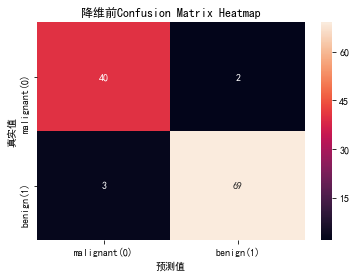

In [9]:
## 绘制混淆矩阵热图
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test,y_pred),
                 annot=True,fmt='d',
                 xticklabels=["malignant(0)","benign(1)"],
                 yticklabels=["malignant(0)","benign(1)"]
                )
    
ax.set_ylabel('真实值')
ax.set_xlabel("预测值")
ax.set_title('降维前Confusion Matrix Heatmap')

结论： 采用未降维的数据进行预测，模型效果还可以。 接下来，使用PCA进行降维，将30维降到15维，采用同样的模型再看预测效果如何？

## 降维后(PCA):LinearSVC建模及评估
><img src="./imgs/chap09/fig09_02.png" width=80%>
<img src="./imgs/chap09/fig09_03.png" width=80%>

### PCA降维
> 将原来的30维降至15维，即`n_components=15`

In [10]:
# PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

## 训练集(X_train_scaled)降维
X_train_pca = pca.fit_transform(X_train_scaled)

## 测试集(X_test_scaled)降维
X_test_pca = pca.transform(X_test_scaled)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\online_lda.py:29: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [11]:
# 查看方差贡献率
pca.explained_variance_ratio_.sum()

0.9872954280920222

解析：贡献率数值的意义说明，虽然X数据由原30维度降到了15维，但能解释近99%的方差信息。

### 使用降维后的数据建模
> 使用`X_train_pca`和`X_test_pca`重新建模，并评估效果

In [12]:
# 再次建立软间隔SVM模型比较效果

## 建模
from sklearn.svm import LinearSVC
model_svc_pca = LinearSVC()

## 训练
model_svc_pca.fit(X_train_pca,y_train)

## 得到测试集预测标签
y_pred_pca = model_svc_pca.predict(X_test_pca)

## 输出测试集预测正确率
score_pca = model_svc_pca.score(X_test_pca,y_test)
print("降维后LinearSVC的预测正确率score_svc：",score_pca)

降维后LinearSVC的预测正确率score_svc： 0.9649122807017544


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  indices = (scores > 0).astype(np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\base.py:291: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` b

Text(0.5, 1, '降维后Confusion Matrix Heatmap')

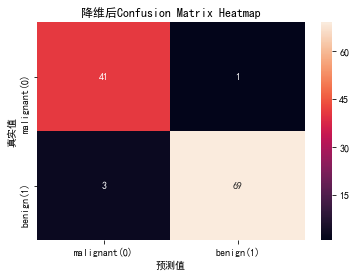

In [13]:
## 绘制混淆矩阵热图
from sklearn.metrics import confusion_matrix
ax = sns.heatmap(confusion_matrix(y_test,y_pred_pca),
                 annot=True,fmt='d',
                 xticklabels=["malignant(0)","benign(1)"],
                 yticklabels=["malignant(0)","benign(1)"]
                )
    
ax.set_ylabel('真实值')
ax.set_xlabel("预测值")
ax.set_title('降维后Confusion Matrix Heatmap')

解析：降维后模型精度有所提升，说明降维提高了模型的泛化能力。

## PCA降维可视化
> 为方便可视化，可将X_train_scaled数据降至2维，即`n_components=2`  <br>
使用二维数据做scatter，x轴为第一维数据，y轴为第二维数据

Text(0, 0.5, 'Second principal component')

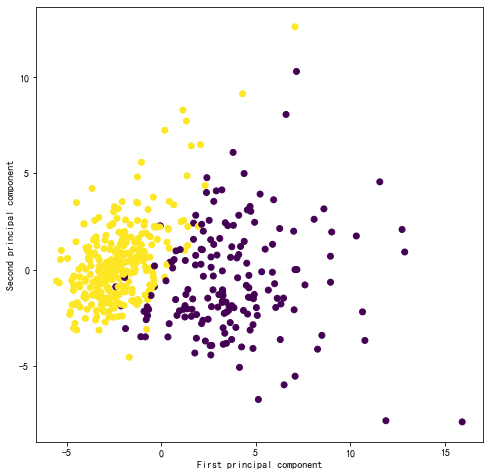

In [14]:
# 利用PCA将训练集降至2维进行可视化
X_train_pca2 = PCA(n_components=2).fit_transform(X_train_scaled)

plt.figure(figsize=(8, 8))
plt.scatter(X_train_pca2[:, 0], X_train_pca2[:, 1], c=y_train)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')

分析：虽然点有重叠，但基本能分开，毕竟由30维-->2维，仅从可视化方面看，效果很不错。

# LDA
> * 线性判别分析LDA(Linear Discriminant Analysis)是一种典型的**有监督线性降维方法**.<br>
> * LDA的目标是利用样本的类别标签信息，找到一个利于数据分类的线性低维表示。目标可从两个角度来量化:
>>* 第一个角度是使得降维后相同类样本尽可能近，使用类内离散度 (within-class scatter)度量
>>* 第二个角度是使得降维后不同类样本尽可能远，使用类间离散度 (between-class scatter)度量

> <img src="./imgs/chap09/fig09_04.png" width=70%>
> <img src="./imgs/chap09/fig09_05.png" width=70%>


>* 由于LDA是有监督的，即有标签的，所以可直接使用LDA模型进行predict()<br>

> 利用LDA对鸢尾花iris进行分类
>> * 150个样本，
* 4个特征：sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)'，
* 3个类别：'setosa', 'versicolor', 'virginica'

## 数据EDA

In [15]:
# 载入数据
from sklearn import datasets
iris = datasets.load_iris()

## 获取data->X
X = iris.data

## 获取target->y
y = iris.target

## 获取feature_names->feature_names
feature_names = iris.feature_names
print("feature_names:",feature_names)

## 获取target_names->target_name
target_names = iris.target_names
print("target_names:",target_names)

feature_names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
target_names: ['setosa' 'versicolor' 'virginica']


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:241: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  target = np.empty((n_samples,), dtype=np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\datasets\base.py:245: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, 

In [16]:
## 数据shape
X.shape,y.shape

((150, 4), (150,))

In [17]:
## 查看X前5行数据
X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [18]:
## target平衡性
pd.DataFrame({'target':list(y)}).value_counts()

target
0         50
1         50
2         50
dtype: int64

分析：三类样本是均衡的。

## LDA降维-训练-预测-评估
> 将4维降至2维`n_components=2`  <br>
> 注意：由于LDA是有监督的，即有标签的，所以本身就有predict()方法

In [19]:
# 划分训练集和测试集
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.2,
                                                random_state=10,
                                                stratify=y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the rele

In [20]:
# 训练模型并评估模型
## 创建LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(n_components=2)

## 训练
lda.fit(X_train,y_train)

## 预测
y_pred = lda.predict(X_test)

In [22]:
## 输出方差贡献率
lda.explained_variance_ratio_.sum()

0.9999999999999999

解析：使用LDA对X进行降维，虽然特征X由原来的4维降到了2维，但这两个维度的特征基本100%解释了之前的四个特征。

In [23]:
## 模型预测正确率
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

1.0

结论：模型在测试集上达到了1.

## LDA与PCA可视化对比
> * 使用PCA将iris的X_train降至2维，然后进行scatter可视化
* 将LDA(n_components=2)的特征进行scatter可视化

In [24]:
# 分别使用PCA和LDA将训练集X_train降到2个维度

## 构建PCA(n_components=2)
pca = PCA(n_components=2)
## 将X_train --> X_pca
X_pca = pca.fit_transform(X_train)

print("PCA(2)降维的方差贡献率",sum(pca.explained_variance_ratio_))

## 构建lda = LinearDiscriminantAnalysis(n_components=2)
lda = LinearDiscriminantAnalysis(n_components=2)
## 将X_train --> X_lda
X_lda = lda.fit(X_train, y_train).transform(X_train)
print("LDA(2)降维的方差贡献率",sum(lda.explained_variance_ratio_))

PCA(2)降维的方差贡献率 0.9769983071749602
LDA(2)降维的方差贡献率 0.9999999999999999


Text(0.5, 1.0, 'LDA of iris dataset')

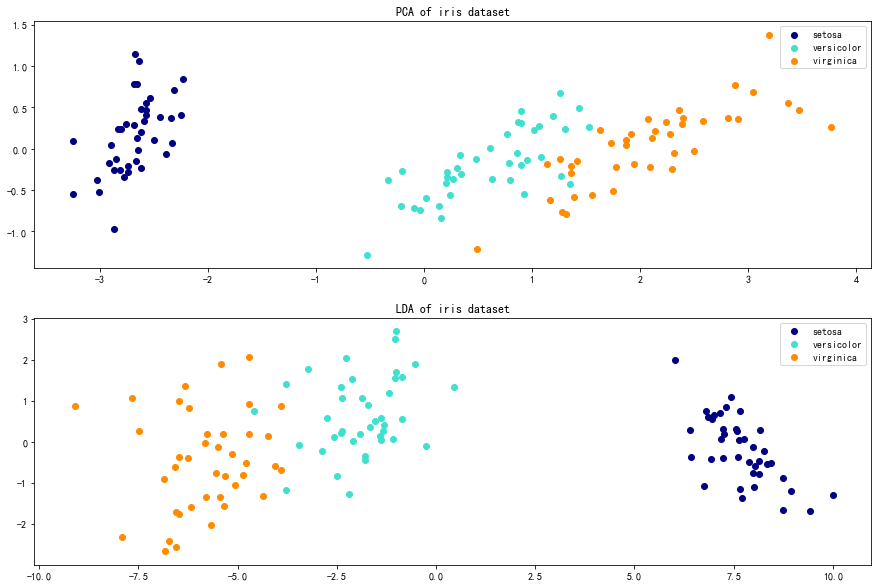

In [25]:
## PCA和LDA降维结果进行可视化对比
plt.figure(figsize=(15,10))

# 一个类别一种颜色：(0,1,2)<=>('setosa' 'versicolor' 'virginica')<=>('navy','turquoise','darkorange')
colors = ['navy', 'turquoise', 'darkorange']  # 海军色，龟绿色，暗橘色

# PCA结果可视化
plt.subplot(2,1,1)
for color, i, target_name in zip(colors,(0,1,2),target_names):
    plt.scatter(X_pca[y_train==i,0],X_pca[y_train==i,1],
                c=color,label=target_name)
plt.legend(loc="best",shadow=False, scatterpoints=1)
plt.title("PCA of iris dataset")

# LDA结果可视化
plt.subplot(2,1,2)
for color, i, target_name in zip(colors,(0,1,2),target_names):
    plt.scatter(X_lda[y_train==i,0],X_lda[y_train==i,1],
                c=color,label=target_name)
plt.legend(loc="best",shadow=False, scatterpoints=1)
plt.title("LDA of iris dataset")


结论：从方差贡献率和可视化图看，LDA效果要好于PCA。

# NMF
> <img src="./imgs/chap09/fig09_06.png"  width=70%>

> <img src="./imgs/chap09/fig09_06_1.png"  width=70%>

>>算法流程请参见论文《Algorithms for Non-negative Matrix Factorization》
https://papers.nips.cc/paper/1861-algorithms-for-non-negative-matrix-factorization.pdf

> 数据集
>> 利用`NMF`还原人脸图像：AT&T脸部数据集包含1992年4月至1994年4月在实验室拍摄的一组脸部图像;一共400张图片，来自40个不同的人，每个人10张图片，图片大小为64×64.

>★ Windows系统下改变scikit_learn_data文件夹默认路径
> ```python
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True, random_state=10)
```
>> * 问题：使用sklearn下载数据集时，会保存到本地的默认路径下，如“C:\Users\...\scikit_learn_data”,如何将该保存路径改为“D:\mydata\”呢？<br>
>> * 解决：增加环境变量SCIKIT_LEARN_DATA，变量值为新路径，如“D:\mydata”。

> ★知识点：Python读取.mat常见操作
>> * mat数据格式是Matlab的数据存储的标准格式,
* `scipy.io`包提供了多种功能来解决不同格式的文件的输入和输出,其中函数`loadmat()`读取mat文件。
* `data = scio.loadmat("test.mat")` : 载入数据,得到的data为字典形式K:V
* `io_whosmat = scio.whosmat("test.mat")`: 列出MATLAB文件中的变量，即K的名称、大小、类型
* `scio.savemat("test.mat", { "x": x, "y": y, "z": z})`: 保存KV数据到mat文件中
>>```python
import scipy.io as scio
data = scio.loadmat("test.mat") 
scio.savemat("test.mat", { "x": x, "y": y, "z": z}) 
io_whosmat = scio.whosmat("test.mat")
```

## 数据EDA

### 从sklearn.datasets加载数据
> 时间可能会很长，甚至加载失败

In [26]:
# 载入数据
from sklearn.datasets import fetch_olivetti_faces
dataset = fetch_olivetti_faces(shuffle=True, random_state=10)
faces = dataset.data

# 查看数据的维度
faces.shape

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\tza2002\scikit_learn_data


(400, 4096)

### 从本地加载
> * 本地文件: file_path = "./dataSets/data_chap9/olivettifaces.mat"
* mat文件为matlib文件，需要处理

In [27]:
import scipy.io as scio
file_path = "./dataSets/data_chap9/olivettifaces.mat"
# 运用loadmat()载入数据 
data = scio.loadmat(file_path) # 得到的data为字典形式
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MAC2, Created on: Mon Mar 18 09:06:53 2002',
 '__version__': '1.0',
 '__globals__': [],
 'faces': array([[ 75, 110,  77, ..., 121,  52, 125],
        [ 83, 108,  75, ..., 119,  49, 125],
        [ 83, 120,  65, ..., 113,  51, 125],
        ...,
        [ 42,  35,  37, ...,  41, 143,  96],
        [ 40,  33,  38, ...,  45, 144,  91],
        [ 38,  37,  37, ...,  46, 146,  93]], dtype=uint8),
 'p': array([[0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
         0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
         0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
         0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025, 0.025,
         0.025, 0.025, 0.025, 0.025]]),
 'u': array([[ 82.6, 151. ,  91.7, ...,  34.4,  64.2, 100.2],
        [ 82.5, 156.3,  88.8, ...,  36.4,  65.2, 100. ],
        [ 84.3, 160.3,  87.6, ...,  38.2,  69. ,  98.6],
        ...,
        [ 68.2,  29.9,  73.7, ..., 

In [27]:
# 通过whosmat函数列出MATLAB文件中的变量
io_whosmat = scio.whosmat(file_path)
io_whosmat

[('faces', (4096, 400), 'double'),
 ('p', (1, 40), 'double'),
 ('u', (4096, 40), 'double'),
 ('v', (4096, 40), 'double')]

In [28]:
## 取出人脸数据，400张图片64X64大小
faces = data["faces"].T
faces.shape

(400, 4096)

In [29]:
type(faces)

numpy.ndarray

In [30]:
## 将400个图片乱序，way1：原地乱序，无返回值
## 不打乱的话前几个都是一个人的脸
np.random.shuffle(faces)

In [31]:
## 将400个图片乱序，way2：有返回值
faces = np.random.permutation(faces)

**自定义绘图函数`plot_gallery`进行图片展示**

In [41]:
# 展示数据
## 展示6张图片，按2行3列放置
n_row, n_col = 2, 3

# 人脸数据图片的显示大小
image_shape = (64, 64)

# 定义绘图函数
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(10, 8))
    plt.suptitle(title, size=15)
    
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        
        # 以灰度图形式显示
        plt.imshow(comp.reshape(image_shape).T, cmap=plt.cm.gray)    # 不加T人脸是横着的
        
        # 不显示坐标轴刻度
        plt.xticks(())
        plt.yticks(())

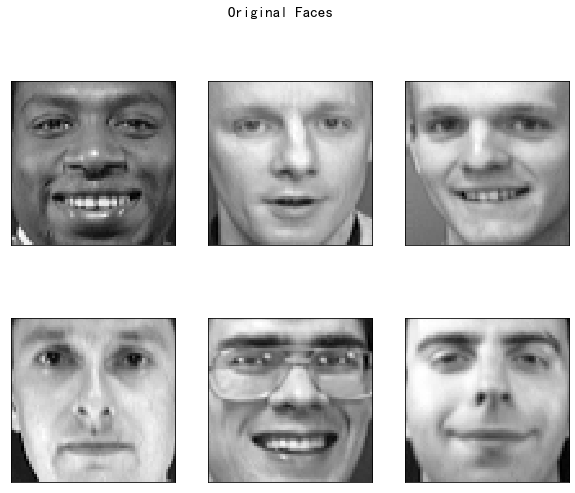

In [42]:
## 展示6张
plot_gallery("Original Faces", faces[:6])

## NMF与PCA还原人脸图像对比

### PCA降维+还原
> 降至6维：`n_components=6, whiten=True,`

In [43]:
# PCA还原人脸图像
## PCA降维
from sklearn.decomposition import PCA
pca = PCA(n_components=10,whiten=True,random_state=10)
pca.fit(faces)

PCA(copy=True, iterated_power='auto', n_components=10, random_state=10,
    svd_solver='auto', tol=0.0, whiten=True)

In [44]:
## 取components_？？？
faces_pca = pca.components_

In [45]:
faces_pca.shape

(10, 4096)

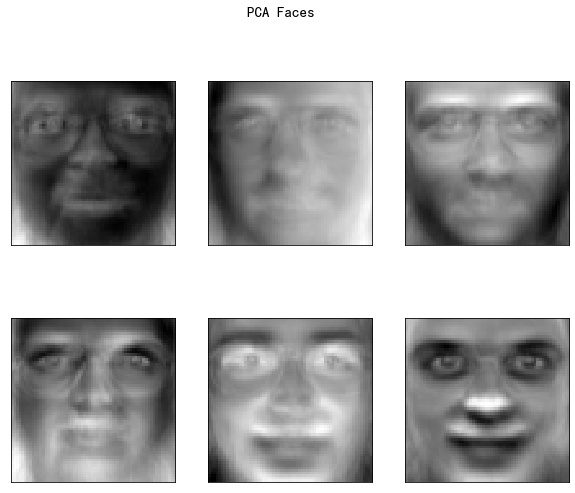

In [46]:
# PCA还原图像
plot_gallery("PCA Faces", faces_pca[:6])

### MF降维+还原
> `NMF(
    [n_components=None, init='warn',  random_state=None, alpha=0.0, l1_ratio=0.0, shuffle=False],
)`

>`n_components=6, init='nndsvda'`

In [40]:
# NMF还原人脸图像
from sklearn.decomposition import NMF

## NMF降维
nmf = NMF(n_components=6, init='nndsvda', random_state=10)
nmf.fit(faces)
faces_nmf = nmf.components_

# 还原图像
plot_gallery("NMF Faces", faces_nmf[:6])

NameError: name 'plot_gallery' is not defined

结论：面部特征，PCA的较模糊，NMF的较清晰。

# 基于流形学习的降维方法
> * 无监督，非线性方法
>* 流形：一个低维空间在一个高维空间中被扭曲之后的结果，低维流形嵌入在高维空间中
>* 形象解释：“一块布是二维平面，把它在三维空间中扭一扭，就变成了一个流形”
>> <img src="./imgs/chap09/fig09_00.png" width=40%>

>* 主要方法
>> <img src="./imgs/chap09/fig09_01_1.png" width=60%>

>* 数据集
>> 构造三维S型曲面

## 数据EDA
> 构造三维S型曲面:`datasets.make_s_curve(n_samples=100,noise=0.0, random_state=None)`

In [39]:
# 载入必要库
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
%matplotlib inline

In [40]:
# 产生数据
n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=10)

Text(0.5, 0.92, 'S Curve')

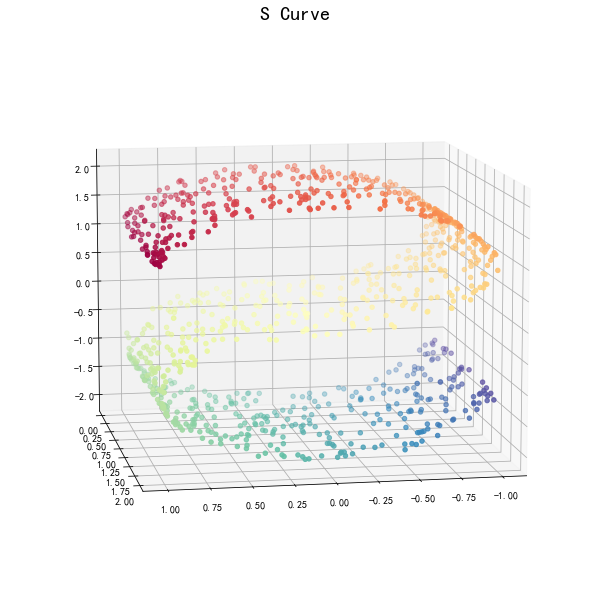

In [41]:
# 绘图S型曲面
fig = plt.figure(figsize=(12, 8))
ax = Axes3D(fig, elev=10, azim=80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title('S Curve', fontsize=20)

**接下来，分别采用LLE,MDS,t-SNE将以上三维数据降至二维，并绘图**

 ## LLE
>* 基于流形学习的降维方法--局部线性嵌入（LLE）
>* LLE算法思想
>> * 将数据降到低维空间中，**保留数据局部的线性关系**
>> * 每一个样本点可以写成其 𝑘 个近邻点的线性组合，从高维嵌入（embedding）到低维时尽量保持局部的线性关系

>* LLE类
>> <img src="./imgs/chap09/fig09_08.png" width=90%>

> 重点，两个超参：
>> * `n_neighbors`不同近邻数对降维结果的影响
>> * `method`不同重构算法对降维结果的影响

### LLE的不同`n_neighbors`
>**下面进行LLE降维，并考察不同近邻数对降维结果的影响：**

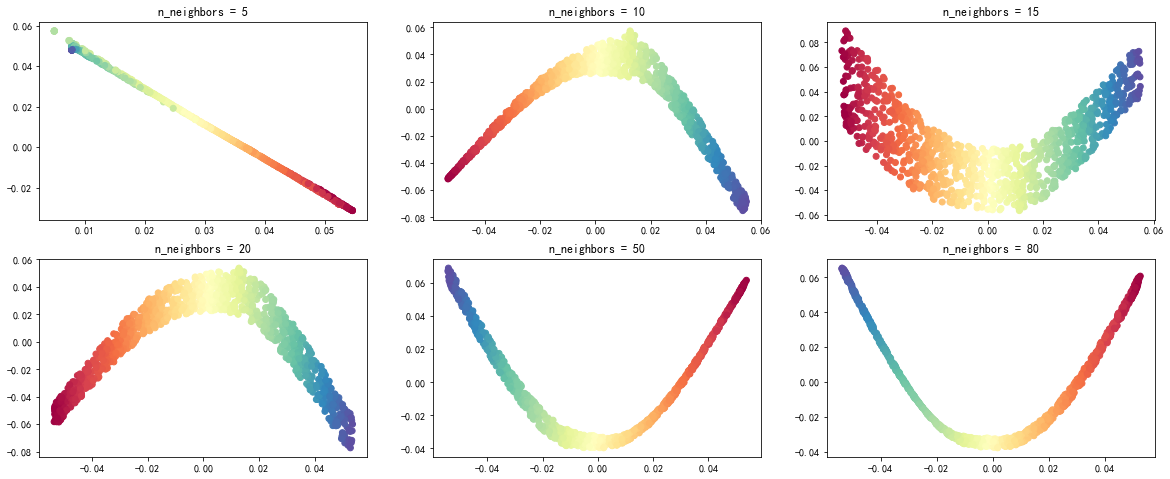

In [42]:
from sklearn.manifold import LocallyLinearEmbedding

# 设置不同近邻数
n_neighbors = [5, 10, 15, 20, 50, 80] 

# 降至2维
n_components = 2

fig = plt.figure(figsize=(20, 8))

for i, number in enumerate(n_neighbors):
    # LLE进行降维
    Y = LocallyLinearEmbedding(n_neighbors=number,
                               n_components=n_components, 
                               random_state=10).fit_transform(X)
 
    # 绘图
    ax = fig.add_subplot(231 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("n_neighbors = %s" % (number))

分析：降维后颜色相近的点聚集在一起，证明保留了数据局部的线性关系

### LLE的不同`method`
>**下面进行LLE降维，并考察不同重构算法对降维结果的影响：**

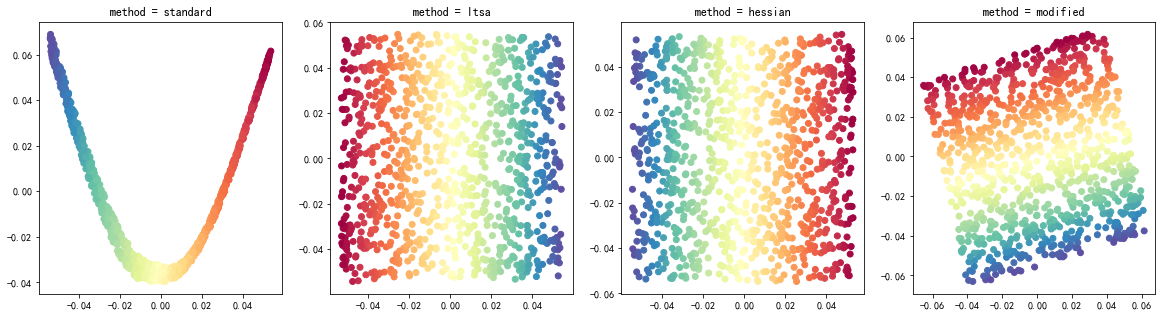

In [43]:
# 设置不同的算法
method_s = ['standard', 'ltsa', 'hessian', 'modified']

# 降至2维
n_components = 2

fig = plt.figure(figsize=(20, 5))

for i, method in enumerate(method_s):
    # LLE进行降维，近邻数固定为50
    Y = LocallyLinearEmbedding(n_neighbors=50, 
                               n_components=n_components, 
                               method=method,
                               random_state=10).fit_transform(X)
 
    # 绘图
    ax = fig.add_subplot(141 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("method = %s" % (method))


解析：采用method=Itsa 和 mthod=hessian的重构算法，降维效果比较理想。

## MDS
> * 基于流形学习的降维方法--多维尺度变换(Multi-dimensional Scaling，MDS) <br>
> * MDS思想
>>* 目标是找到数据的低维表示，使得降维前后样本之间的相似度信息尽量得以保留，**注重保留全局特性**
>>* 多维尺度变换能够只利用样本间的距离信息，找到每一个样本的特征表示，且在该特征表示下样本的距离与原始的距离尽量接近

>* MDS类
>> <img src="./imgs/chap09/fig09_09.png" >

### MDS降维
> **下面进行MDS降维，将三维S型曲线将至2维,并与LLE结果进行比较：**

Text(0.5, 1.0, 'MDS')

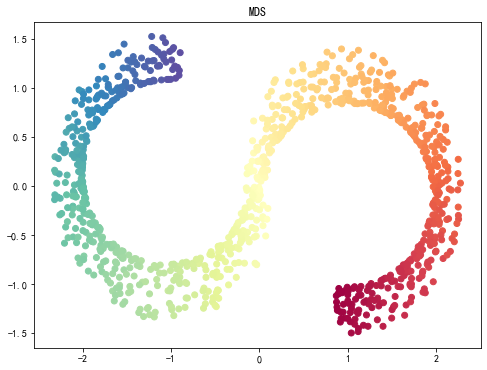

In [44]:
# 利用MDS将三维S型曲线将至2维
from sklearn.manifold import MDS
n_components=2

## 使用MDS降维并得到降维结果
mds = MDS(n_components, random_state=10)
Y = mds.fit_transform(X)

## 降维可视化
plt.figure(figsize=(8, 6))
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS") 

解析： 从结果看MDS降维保留了整体性特征

### MDS的保距特性
> * 多维尺度变换能够只利用样本间的距离信息，找到每一个样本的特征表示，且在该特征表示下样本的距离与原始的距离尽量接近。
* 尽量脱离样本本身，而最大程度的保留样本间的距离信息。
* 例：根据城市间距离还原城市坐标

In [45]:
## 构建距离矩阵
import pandas as pd

d = pd.DataFrame([[0, 1064, 1055, 1187],
                  [1064, 0, 1675, 1717],
                  [1055, 1675, 0, 2192],
                  [1187, 1717, 2192, 0]], 
                 columns=['北京','上海','哈尔滨','兰州'], 
                 index=['北京','上海','哈尔滨','兰州'])
d

,北京,上海,哈尔滨,兰州
北京,0,1064,1055,1187
上海,1064,0,1675,1717
哈尔滨,1055,1675,0,2192
兰州,1187,1717,2192,0


分析：
> * 以上是个4x4的矩阵(16个数据)，可以看做是有4维特征，
* 现在将其降至2维(8个数据)，并把降维后的数据scatter到平面上，
* 看是否保留了样本样本间的距离信息?

In [46]:
## 使用MDS降维并得到降维2维的结果
n_components = 2
mds = MDS(n_components, random_state=10)
Y = mds.fit_transform(d)

D:\virtualEnvs\MLenv1\lib\site-packages\sklearn\manifold\_mds.py:441: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


In [47]:
Y

array([[ -230.44452273,  -187.28155514],
       [ 1221.98579579,   538.02394261],
       [  189.37394465, -1715.94752822],
       [-1180.91521771,  1365.20514075]])

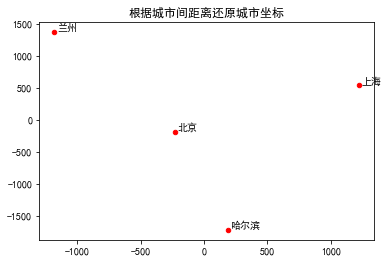

In [48]:
## 降维可视化
plt.figure(figsize=(6, 4))
plt.scatter(Y[:, 0], Y[:, 1], c='red', s=20)

plt.title("根据城市间距离还原城市坐标") 
for item,city in enumerate(d.columns):
    plt.text(Y[item, 0]+20, Y[item, 1]+20, city)

解析：看见MDS降维后，很好地保持了样本间的距离。

## t-SNE
> * 基于流形学习的降维方法--t-分布领域嵌入算法（t-SNE）
> * SNE算法原理
>>  <img src="./imgs/chap09/fig09_10.png" width=60%>
>>  <img src="./imgs/chap09/fig09_10_1.png" width=60%>
>>  <img src="./imgs/chap09/fig09_10_2.png" width=60%>

>* TSNE原理
>> <img src="./imgs/chap09/fig09_10_3.png" width=60%>

>* TSNE类
>> <img src="./imgs/chap09/fig09_10_4.png" width=60%>

>* 重点，一个超参数：
>> `perplexs`：小保局部，大保全局 

**下面进行t-SNE降维，并分析不同`perplexs`对结果的影响：**

### t-SNE降维
> 利用t-SNE将三维S型曲线将至2维

Text(0.5, 1.0, 't-SNE')

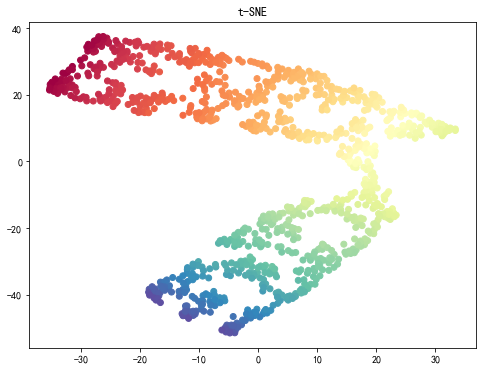

In [49]:
# 利用t-SNE将三维S型曲线将至2维
from sklearn.manifold import TSNE
n_components = 2

## 使用t-SNE降维并得到降维结果
tsne = TSNE(n_components, random_state=10)
Y = tsne.fit_transform(X)

## 降维可视化
plt.figure(figsize=(8, 6))
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE")

分析：仅从上图看，谈不上效果的好快，仅能看出降维后保留了源数据的部分特性。

### t-SNE的不同`perplexs`
> 不同困惑度对t-SNE降维结果的影响

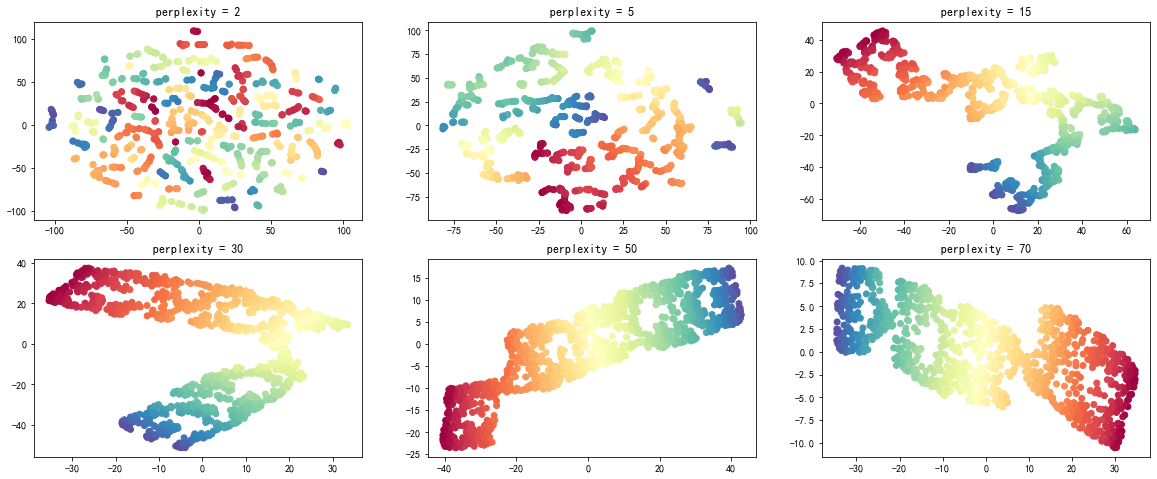

In [50]:
# 不同困惑度对t-SNE降维结果的影响

# 设置不同困惑度
perplex_s = [2, 5, 15, 30, 50, 70]
# 降至2维
n_components = 2

fig = plt.figure(figsize=(20, 8))

for i, perplex in enumerate(perplex_s):
    # t-SNE进行降维
    Y = TSNE(n_components, 
             perplexity=perplex, 
             random_state=10).fit_transform(X)
 
    # 绘图
    ax = fig.add_subplot(231 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("perplexity = %s" % (perplex))

解析：困惑度`perplexs`可以反映一个点附近的有效近邻点个数,随着`perplexs`的增加考虑的邻域的点增多，其效果也有所提升。

### 实例:TSNE降维digits
> * 手写数字识别数据集：`from sklearn.datasets import load_digits`
* load_digits(n_class=10, return_X_y=False, as_frame=False)
* data : {ndarray, dataframe} of shape (1797, 64)
* target: {ndarray, Series} of shape (1797,)
* 使用数据集中的5个类别(n_class=5)的数字数据，进行TSNE降维后，可视化

#### 载入digits

In [51]:
# 载入手写数字识别数据集
from sklearn.datasets import load_digits
## 选择其中的五类
digits = load_digits(n_class=5)

In [52]:
## 取出data，target
X = digits.data
y = digits.target
## 仅取前五类数字的shape
X.shape,y.shape

((901, 64), (901,))

In [53]:
## 第一个数字的X,并转成8X8，看像不像个0
# X[0].reshape((8,8))
X[0,:].reshape((8,8))

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [54]:
## 查看第一个X的标签
y[0]

0

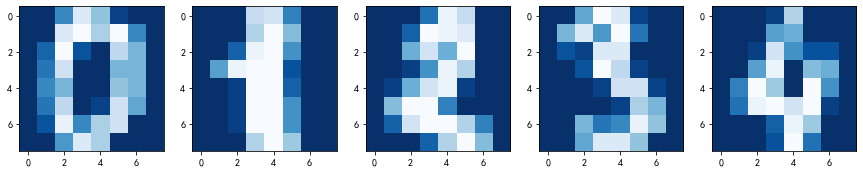

In [55]:
# 展示5个数字
fig = plt.figure(figsize=(15, 8))

for i in range(5):
    ax = fig.add_subplot(151 + i)
    plt.imshow(X[i,:].reshape(8, 8), cmap=plt.cm.Blues_r)  # cmap=plt.cm.rainbow

#### 构建展示函数
> * 构建2D展示函数
> * 构建3D展示函数

In [56]:
# 构建2D展示函数
import numpy as np

def plot_embedding_2d(X, title):
    
    ## 数据归一化，缩放至[0,1]之间
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    
    ## 绘制散点图
    fig = plt.figure(figsize=(12, 8))
    for i in range(X.shape[0]):
        plt.text(X[i][0], X[i][1],str(digits.target[i]),   # digits.target[i]《=》y[i]
                 color=plt.cm.Set1(y[i] / 5.),             # 不同的数字不同的颜色
                 fontdict={'size': 9})                     # 9号字体
        
    ## 添加标题
    plt.title(title)

In [57]:
# 构建3D绘图函数
def plot_embedding_3d(X, title):
    
    ## 数据归一化
    x_min, x_max = np.min(X,axis=0), np.max(X,axis=0)
    X = (X - x_min) / (x_max - x_min)
    
    ## 绘制散点图
    fig = plt.figure(figsize=(8,6))
    ax = Axes3D(fig, elev=10, azim=60)
    for i in range(X.shape[0]):
        ax.text(X[i][0], X[i, 1], X[i,2],str(digits.target[i]),
                 color=plt.cm.Set1(y[i] / 5.),
                 fontdict={ 'size': 9})
    
    ## 添加标题
    plt.title(title)

#### t-SNE降维digits并展示
>* t-SNE将手写数字数据集由64维降至2维并展示
>* t-SNE将手写数字数据集由64维降至3维并展示

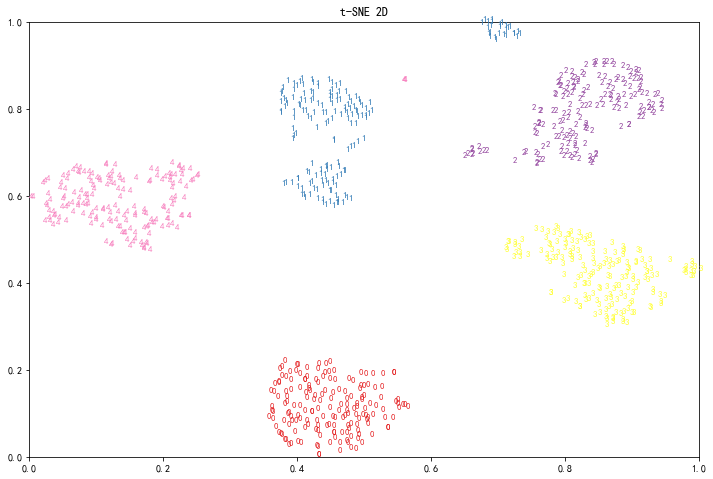

In [58]:
# 利用t-SNE将手写数字识别数据集降至2维
from sklearn.manifold import TSNE

## 建模
tsne = TSNE(n_components=2, random_state=10)
## 降维
Y = tsne.fit_transform(X)
## 展示（2维）
plot_embedding_2d(Y, "t-SNE 2D")


分析：1给分成了两堆，4有一个单飞了额，2有一小部分偏离，0和5分的比较好。

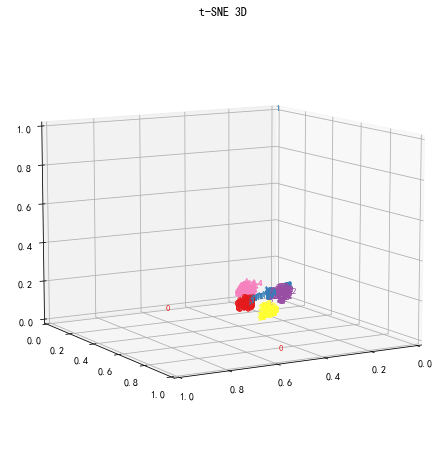

In [59]:
# 利用t-SNE将手写数字识别数据集降至3维

## 建模
tsne = TSNE(n_components=3, random_state=10)
## 降维
Y = tsne.fit_transform(X)
## 展示（3维）
plot_embedding_3d(Y, "t-SNE 3D")

分析：明显有两个0单飞了；图上最大的特点是第三维的值基本在0.1以下，所以可以推断，用2个维度就可以了。

# 小结
>降维方法：
>>◆基于矩阵分解的降维方法:
>>>* 主成分分析（PCA）：无监督，线性降维
* 线性判别分析（LDA）：**有监督**，线性降维
* 非负矩阵分解（NMF）：无监督，是一种PCA，要求数据和成分都非负，适合图像、文本等结构化数据

>>◆基于流形学习的降维方法: <br>
>>**流行**：一个低维空间在一个高维空间中被扭曲之后的结果。（瑞士卷）
>>>* 局部线性嵌入（LLE）：非线性，注重保留局部特征，超参`n_neighbors`,`method`。
* 多维标度法（MDS）：非线性，注重保留全局特征，只利用样本间的距离信息，找到每一个样本的特征表示。
* t-分布随机邻域嵌入算法（t-SNE）：非线性，超参`困惑度(perplexity)`:5-50间可调,小注重局部，大注重全局。

# 练习_ 例1_iris
>数据集iris共有150条数据，5个字段，数据集已导入，保存在DataFrame对象data中，字段及说明如下：

> * 请利用Sklearn建立线性判别分析模型，使用前4个字段预测鸢尾花的类别
* 将数据降到2维后，绘制散点图，横轴为降维后的第一特征，纵轴为降维后的第二特征，点的颜色按鸢尾花的类别进行分类

In [ ]:
#导入相关库
import matplotlib.pyplot as plt
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np


# 数据处理
data = pd.read_csv('iris_data.txt', sep=',')
data.columns = ['X1 sepal length (cm)',
                'X2 sepal width (cm)',
                'X3 petal length (cm)',
                'X4 petal width (cm)',
                'y class label']

X = data[['X1 sepal length (cm)', 'X2 sepal width (cm)', 'X3 petal length (cm)', 'X4 petal width (cm)']]
y = data['y class label']
target_names = np.array(['setosa', 'versicolor', 'virginica'])
enc = LabelEncoder()
label_encoder = enc.fit(y)
y = label_encoder.transform(y)
label_dict = {0: 'Setosa', 1: 'Versicolor', 2: 'Virginica'}

# LDA降维
lda = LinearDiscriminantAnalysis(n_components=____)
X_r2 = lda.fit(____,  ____).transform(____)

# 绘制散点图
fig = plt.figure(figsize=(8, 6))
for i in range(____):
    plt.scatter(X_r2[y == ____, ____], X_r2[____ == ____, ____], label=target_names[____])

答案：
>
```python
lda = LinearDiscriminantAnalysis(n_components=2)
X_r2 = lda.fit(X, y).transform(X)

fig = plt.figure(figsize=(8, 6))
for i in range(3):
    plt.scatter(X_r2[y ==i, 0], X_r2[y == i, 1], label=target_names[i])
    
```